In [1]:
import pydicom
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split


In [2]:
def load_dicom_image(path, img_size=256):
    # Load dicom and convert to 256x256 RGB image
    dicom = pydicom.dcmread(path)
    image = dicom.pixel_array
    image = Image.fromarray(image).convert('RGB')
    image = image.resize((img_size, img_size))
    return np.array(image) / 255.0

    # Convert to TensorFlow tensor
    return tf.convert_to_tensor(image, dtype=tf.float32)


In [3]:
def process_patient_images(patient_folder, img_size=256):
    """
    Process all DICOM images of a patient and return a single representative array.
    This is a placeholder function prior to deciding how to handle multiple images with a particular patient
    """
    images = []
    for filename in os.listdir(patient_folder):
        if filename.endswith('.dcm'):
            path = os.path.join(patient_folder, filename)
            image = load_dicom_image(path, img_size=img_size)
            images.append(image)
    
    # Placeholder: simply return the first image for now
    if images:
        return images[0]
    else:
        return None

In [4]:
def create_train_val_datasets(root_dir, img_size=256, batch_size=32, val_split=0.2):
    all_images = []
    all_labels = []

    patient_folders = []
    for condition in os.listdir(root_dir):
        condition_path = os.path.join(root_dir, condition)
        if not os.path.isdir(condition_path):
            continue
        
        label = 1 if condition.lower() == 'cancer' else 0
        for patient_folder_name in os.listdir(condition_path):
            patient_folder_path = os.path.join(condition_path, patient_folder_name)
            if os.path.isdir(patient_folder_path):
                patient_folders.append((patient_folder_path, label))
    
    # Split patient folders into training and validation sets
    train_folders, val_folders = train_test_split(patient_folders, test_size=val_split, random_state=42)

    # Process training data
    for folder_path, label in train_folders:
        image = process_patient_images(folder_path, img_size=img_size)
        if image is not None:
            all_images.append(image)
            all_labels.append(label)
    
    # Convert training lists to tensors and create a dataset
    train_images = tf.stack(all_images)
    train_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=1024).batch(batch_size)
    
    # Reset for validation data processing
    all_images = []
    all_labels = []

    # Process validation data
    for folder_path, label in val_folders:
        image = process_patient_images(folder_path, img_size=img_size)
        if image is not None:
            all_images.append(image)
            all_labels.append(label)
    
    # Convert validation lists to tensors and create a dataset
    val_images = tf.stack(all_images)
    val_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
    
    return train_dataset, val_dataset


In [5]:
""" def create_dataset(root_dir, img_size=256, batch_size=32):
    # Placeholder lists for images and labels
    all_images = []
    all_labels = []
    
    # Navigate through the root directory and process each patient's images
    for condition in os.listdir(root_dir):
        condition_path = os.path.join(root_dir, condition)
        if not os.path.isdir(condition_path):
            continue
        
        label = 1 if condition.lower() == 'cancer' else 0
        
        for patient_folder_name in os.listdir(condition_path):
            patient_folder_path = os.path.join(condition_path, patient_folder_name)
            if not os.path.isdir(patient_folder_path):
                continue
            
            representative_image = process_patient_images(patient_folder_path, img_size=img_size)
            if representative_image is not None:
                all_images.append(representative_image)
                all_labels.append(label)
    
    # Convert lists to tensors
    dataset_images = tf.stack(all_images)
    dataset_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    
    # Create a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dataset_images, dataset_labels))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    
    return dataset """

In [5]:
""" from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def build_model(input_shape=(256, 256, 3), dropout_rate=0.5, l2_reg=0.001):
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid',kernel_regularizer=l2(l2_reg))
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model
 """

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def build_model_with_resnet(input_shape=(256, 256, 3), dropout_rate=0.5, l2_reg=0.001):
    base_model = ResNet50(input_shape=input_shape,
                          include_top=False,
                          weights='imagenet')
    base_model.trainable = False  

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [6]:
# train_dataset = create_dataset('/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/CapstoneData', img_size=256, batch_size=32)
train_dataset, val_dataset = create_train_val_datasets(root_dir='/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/CapstoneData', img_size=256, batch_size=32)

In [7]:
model = build_model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Or another appropriate loss function
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

/var/folders/kq/j6d8h1bx4z5cv8c9hc3hv6yw0000gn/T/ipykernel_3693/194924657.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape,


In [8]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset) 

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.5321 - auc: 0.5029 - loss: 0.8591 - precision: 0.4543 - recall: 0.3814 - val_accuracy: 0.5018 - val_auc: 0.4716 - val_loss: 0.7409 - val_precision: 0.3846 - val_recall: 0.2083
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5051 - auc: 0.4669 - loss: 0.8788 - precision: 0.4606 - recall: 0.4061 - val_accuracy: 0.5018 - val_auc: 0.4693 - val_loss: 0.7303 - val_precision: 0.4051 - val_recall: 0.2667
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4924 - auc: 0.4924 - loss: 0.7878 - precision: 0.3898 - recall: 0.3431 - val_accuracy: 0.5314 - val_auc: 0.4701 - val_loss: 0.7325 - val_precision: 0.4507 - val_recall: 0.2667
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5867 - auc: 0.5897 - loss: 0.7261 - precision: 0.5643 - recall: 0.5324 - val_accuracy: 0.5092 - val_auc: 0.4701 - val_loss: 0.7313 - val_precision: 0.4343 - val_recall: 0.3583
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━

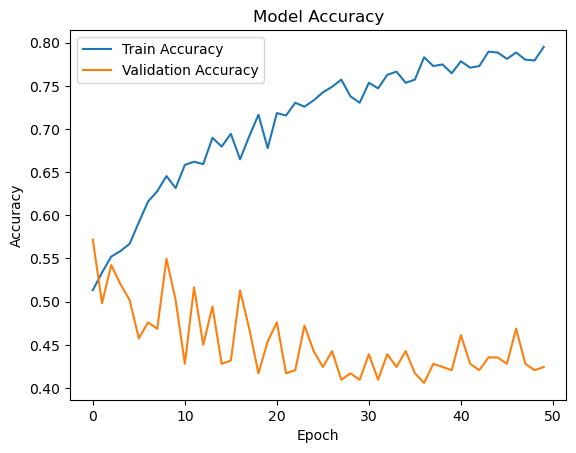

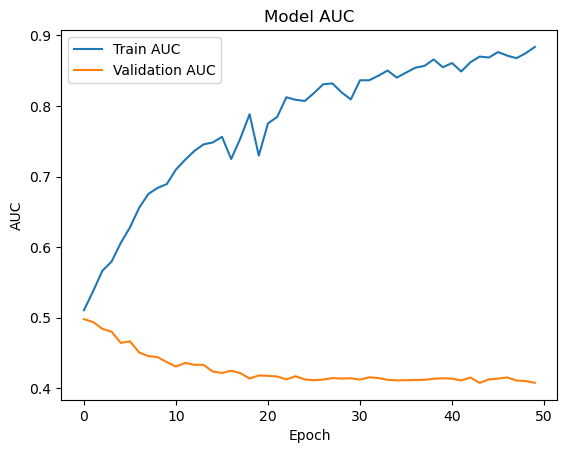

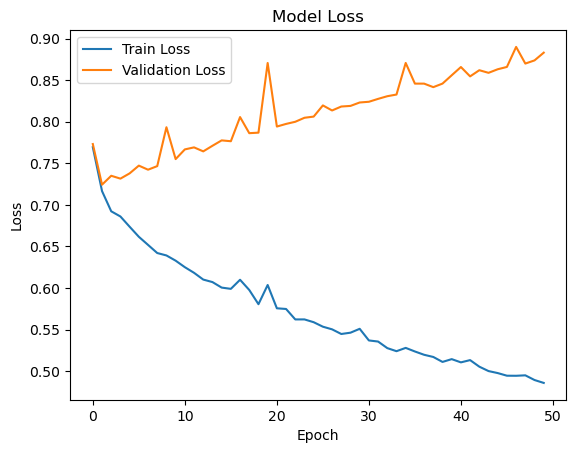

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation AUC values
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')  
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [3]:
# dicom_dir_path = '/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/CapstoneData'  # Directory where DICOM files are stored

tensor([1.], device='mps:0')
